In [127]:
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.linalg import circulant


from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import scienceplots

from sklearn.model_selection import train_test_split

from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import Adam, ClippedAdam

from datetime import datetime
import json
from collections import defaultdict
import itertools

import os
import json

from prod_slda.model import ProdSLDA
from prod_slda.data_utils import *

In [128]:
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [129]:
RESULTS_DIR = '/mnt/swordfish-pool2/ndeas/prob_models/final_results/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/'
DATA_DIR    = '/mnt/swordfish-pool2/ndeas/prob_models/final_results/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/maxdf0.7_mindf20_DATA/'
MODEL_DIRS  = [os.path.join(RESULTS_DIR, mdir) for mdir in os.listdir(RESULTS_DIR) if 'DATA' not in mdir]

BATCH_SIZE  = 256
NUM_WORKERS = 4

DEVICE = torch.device('cuda:0')

plt.style.use('science')

set_seeds(0)

# Data Setup 

In [ ]:
casing, 3, emoji, 20, formality, 2, pos_bigrams, 324, punc tags, 20, sentiment, 3

In [232]:
meta_vectorized['training']

{'casing': <66668x3 sparse matrix of type '<class 'numpy.int64'>'
 	with 72739 stored elements in Compressed Sparse Row format>,
 'emoji_task': <66668x20 sparse matrix of type '<class 'numpy.int64'>'
 	with 113006 stored elements in Compressed Sparse Row format>,
 'formality': <66668x2 sparse matrix of type '<class 'numpy.int64'>'
 	with 88017 stored elements in Compressed Sparse Row format>,
 'pos_bigrams': <66668x324 sparse matrix of type '<class 'numpy.float64'>'
 	with 852253 stored elements in Compressed Sparse Row format>,
 'punc_tags': <66668x20 sparse matrix of type '<class 'numpy.float64'>'
 	with 144710 stored elements in Compressed Sparse Row format>,
 'sentiment_task': <66668x3 sparse matrix of type '<class 'numpy.int64'>'
 	with 89547 stored elements in Compressed Sparse Row format>}

## Data Preprocessing/Loading

In [4]:
bows, meta_vectorized, vectorizer, raw_text, authors_json, meta_features_to_names = load_data(DATA_DIR)   

In [5]:
NUM_DOCS   = bows['training'].shape[0]
VOCAB_SIZE = bows['training'].shape[1]
META_SIZE  = {k:v.shape[1] for k,v in meta_vectorized['training'].items()}
IDX_TO_TERM = {v:k for k,v in vectorizer.vocabulary_.items()}

In [6]:
print(f'BOW Dims: {bows["training"].shape}')
print(f'META Dims: {META_SIZE}')

BOW Dims: (66668, 3098)
META Dims: {'casing': 3, 'emoji_task': 20, 'formality': 2, 'pos_bigrams': 324, 'punc_tags': 20, 'sentiment_task': 3}


# Hyperparameter Tuning Results

In [25]:
def get_model_name(model_dir):
    try:
        pt_file = [fp for fp in os.listdir(model_dir) if fp[-3:] == '.pt'][0]
        return pt_file
    except:
        return None

def get_loss(model_dir):
    # try:
    pt_file = [fp for fp in os.listdir(model_dir) if fp[-3:] == '.pt'][0]
    final_loss = float(pt_file[pt_file.rindex('_') + 1:-3])
    losses = pd.read_csv(os.path.join(model_dir, 'elbos.json'))
    best_loss = losses['val_elbo'].min()
    return final_loss, best_loss
    # except:
    #     return None, None

def extract_hparams(fp):
    try:
        with open(os.path.join(fp, 'info.json')) as f:
            info = json.load(f)

        return info
    except:
        return None

In [26]:
models = [get_model_name(model_dir) for model_dir in MODEL_DIRS]
losses = [get_loss(model_dir) for model_dir in MODEL_DIRS]
final_losses, best_losses = [loss[0] for loss in losses], [loss[1] for loss in losses]
hparams = [extract_hparams(model_dir) for model_dir in MODEL_DIRS]

In [27]:
hparam_res = pd.DataFrame({'checkpoint': models, 
              'final_val_loss': final_losses,
              'best_val_loss': best_losses,
              'hparams': hparams,
              'full_path': [mdir + '/' + model_fp for mdir, model_fp in zip(MODEL_DIRS, models)]})

In [29]:
hparam_res = hparam_res.sort_values('best_val_loss', ascending = True)
hparam_res.to_csv('hparam_tuning_res.csv', index = None)

In [30]:
CHOSEN_MODEL = hparam_res.iloc[0]['full_path']

In [218]:
# Model File for equivalent independent model
# CHOSEN_INDEP_MODEL = '/mnt/swordfish-pool2/ndeas/prob_models/final_results/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-21_20_26_05/model_epoch23_5271.38775062561.pt'
CHOSEN_INDEP_MODEL = '/mnt/swordfish-pool2/ndeas/prob_models/final_results/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-21_21_07_02/model_epoch14_5511.27596282959.pt'

# Perplexity Evaluation

In [35]:
def calc_doc_perp(prod_slda, eval_dl, device, use_style = True):
    total_ce, total_count = 0., 0.
    for batch in tqdm(eval_dl):
        for key in batch.keys():
            if isinstance(batch[key], dict):
                for key2 in batch[key].keys():
                    batch[key][key2] = batch[key][key2].to(device)
            else:
                batch[key] = batch[key].to(device)

        ce, count = prod_slda.doc_reconstruct_ce(batch, use_style = use_style)
        total_ce += ce
        total_count += count
    return torch.exp(total_ce/total_count).item()

def calc_style_perp(prod_slda, eval_dl, device):
    total_ce, total_count = 0., 0.
    for batch in tqdm(eval_dl):
        for key in batch.keys():
            if isinstance(batch[key], dict):
                for key2 in batch[key].keys():
                    batch[key][key2] = batch[key][key2].to(device)
            else:
                batch[key] = batch[key].to(device)

        ce, count = prod_slda.style_reconstruct_ce(batch)
        total_ce += ce
        total_count += count
    return torch.exp(total_ce/total_count).item()

In [36]:
def full_perp_eval(prod_slda, eval_dl, device):
    doc_perp      = calc_doc_perp(prod_slda, eval_dl, device)
    doc_only_perp = calc_doc_perp(prod_slda, eval_dl, device, use_style = False)
    style_perp    = calc_style_perp(prod_slda, eval_dl, device)
    
    return doc_perp, doc_only_perp, style_perp

In [37]:
def perp_by_perc_hidden(prod_slda, bows, meta_vectorized, device, perc_obs_vals = [0.5],
                        batch_size = 64, num_workers = 4, doc_only = True):
    
    doc_perps = []
    doc_only_perps = []
    
    for obs_val in perc_obs_vals:
        
        # Prepare partially hidden data
        eval_dataset = DocMetaData(bows['holdout'], meta_vectorized['holdout'], split_halves = True, perc_obs = obs_val)
        eval_dl = DataLoader(eval_dataset, batch_size = batch_size, num_workers = num_workers, shuffle=True)
        
        doc_perp = calc_doc_perp(prod_slda, eval_dl, device)
        
        doc_perps.append(doc_perp)
        
        if doc_only:
            doc_only_perp = calc_doc_perp(prod_slda, eval_dl, device, use_style = False)
            doc_only_perps.append(doc_only_perp)
    
    if doc_only:
        return doc_perps, doc_only_perps
    else:
        return doc_perps

## Reconstruction Perplexity

In [38]:
eval_dataset = DocMetaData(bows['holdout'], meta_vectorized['holdout'], split_halves = True)
eval_dl = DataLoader(eval_dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)

In [39]:
all_results = defaultdict(list)
for i, model_dir in enumerate(MODEL_DIRS):
    
    print(f'Evaluating model {model_dir.split("/")[-1]} ({str(i+1)} of {len(MODEL_DIRS)})')
    
    model_fp = [os.path.join(model_dir, fp) for fp in os.listdir(model_dir) if fp[-3:] == '.pt'][0]
    prod_slda = torch.load(model_fp).to(DEVICE)
    prod_slda.eval()
    model_file = get_model_name(model_dir)
    
    doc_perp, doc_only_perp, style_perp = full_perp_eval(prod_slda, eval_dl, DEVICE)
    
    all_results['checkpoint'].append(model_file)
    all_results['doc_perp'].append(doc_perp)
    all_results['doc_only_perp'].append(doc_only_perp)
    all_results['style_perp'].append(style_perp)

Evaluating model 2023-12-21_11_36_17 (1 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.20it/s]


Evaluating model 2023-12-21_03_44_05 (2 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.19it/s]


Evaluating model 2023-12-20_22_20_01 (3 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.85it/s]


Evaluating model 2023-12-21_04_31_46 (4 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.58it/s]


Evaluating model 2023-12-21_03_37_54 (5 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.34it/s]


Evaluating model 2023-12-21_04_11_08 (6 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.31it/s]


Evaluating model 2023-12-21_05_26_58 (7 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.55it/s]


Evaluating model 2023-12-21_04_36_13 (8 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.02it/s]


Evaluating model 2023-12-20_22_51_18 (9 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.82it/s]


Evaluating model 2023-12-21_12_27_09 (10 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.33it/s]


Evaluating model 2023-12-21_03_16_09 (11 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.91it/s]


Evaluating model 2023-12-20_22_06_10 (12 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.70it/s]


Evaluating model 2023-12-21_11_47_25 (13 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.68it/s]


Evaluating model 2023-12-21_11_36_36 (14 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.36it/s]


Evaluating model 2023-12-21_03_41_44 (15 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.70it/s]


Evaluating model 2023-12-20_21_54_34 (16 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.19it/s]


Evaluating model 2023-12-21_12_28_24 (17 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.03it/s]


Evaluating model 2023-12-21_03_05_13 (18 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.65it/s]


Evaluating model 2023-12-21_11_53_36 (19 of 107)


100%|██████████| 90/90 [00:05<00:00, 15.08it/s]


Evaluating model 2023-12-20_22_16_35 (20 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.41it/s]


Evaluating model 2023-12-21_02_50_54 (21 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.03it/s]


Evaluating model 2023-12-21_12_34_56 (22 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.42it/s]


Evaluating model 2023-12-21_12_38_15 (23 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.58it/s]


Evaluating model 2023-12-21_12_25_09 (24 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.48it/s]


Evaluating model 2023-12-21_04_51_51 (25 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.44it/s]


Evaluating model 2023-12-21_03_09_50 (26 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.59it/s]


Evaluating model 2023-12-20_22_40_53 (27 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.37it/s]


Evaluating model 2023-12-21_12_19_42 (28 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.82it/s]


Evaluating model 2023-12-20_22_47_43 (29 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.93it/s]


Evaluating model 2023-12-21_03_44_02 (30 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.70it/s]


Evaluating model 2023-12-21_12_18_10 (31 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.11it/s]


Evaluating model 2023-12-20_22_24_43 (32 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.59it/s]


Evaluating model 2023-12-21_03_17_19 (33 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.75it/s]


Evaluating model 2023-12-21_03_14_07 (34 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.17it/s]


Evaluating model 2023-12-21_12_00_23 (35 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.15it/s]


Evaluating model 2023-12-21_04_45_36 (36 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.61it/s]


Evaluating model 2023-12-21_02_51_27 (37 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.59it/s]


Evaluating model 2023-12-21_02_58_52 (38 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.19it/s]


Evaluating model 2023-12-21_04_00_47 (39 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.24it/s]


Evaluating model 2023-12-20_22_29_13 (40 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.77it/s]


Evaluating model 2023-12-21_04_31_56 (41 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.27it/s]


Evaluating model 2023-12-21_03_01_13 (42 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.17it/s]


Evaluating model 2023-12-20_22_40_39 (43 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.35it/s]


Evaluating model 2023-12-21_03_25_59 (44 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.40it/s]


Evaluating model 2023-12-21_03_26_02 (45 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.79it/s]


Evaluating model 2023-12-21_03_13_09 (46 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.08it/s]


Evaluating model 2023-12-21_02_51_44 (47 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.80it/s]


Evaluating model 2023-12-20_22_02_10 (48 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.79it/s]


Evaluating model 2023-12-21_03_50_43 (49 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.27it/s]


Evaluating model 2023-12-21_03_53_20 (50 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.67it/s]


Evaluating model 2023-12-20_22_09_06 (51 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.62it/s]


Evaluating model 2023-12-20_22_34_29 (52 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.24it/s]


Evaluating model 2023-12-21_12_17_24 (53 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.98it/s]


Evaluating model 2023-12-21_12_13_22 (54 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.95it/s]


Evaluating model 2023-12-20_21_54_51 (55 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.66it/s]


Evaluating model 2023-12-21_04_02_32 (56 of 107)


100%|██████████| 90/90 [00:05<00:00, 15.29it/s]


Evaluating model 2023-12-21_04_17_07 (57 of 107)


100%|██████████| 90/90 [00:05<00:00, 15.43it/s]


Evaluating model 2023-12-21_04_14_21 (58 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.18it/s]


Evaluating model 2023-12-20_22_12_29 (59 of 107)


100%|██████████| 90/90 [00:05<00:00, 15.04it/s]


Evaluating model 2023-12-20_22_13_08 (60 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.85it/s]


Evaluating model 2023-12-21_11_50_08 (61 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.46it/s]


Evaluating model 2023-12-20_22_03_18 (62 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.67it/s]


Evaluating model 2023-12-21_04_38_42 (63 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.44it/s]


Evaluating model 2023-12-21_03_51_36 (64 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.99it/s]


Evaluating model 2023-12-21_12_23_57 (65 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.38it/s]


Evaluating model 2023-12-21_11_37_11 (66 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.22it/s]


Evaluating model 2023-12-20_22_36_42 (67 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.69it/s]


Evaluating model 2023-12-20_22_03_33 (68 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.23it/s]


Evaluating model 2023-12-21_04_28_41 (69 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.70it/s]


Evaluating model 2023-12-20_22_26_52 (70 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.98it/s]


Evaluating model 2023-12-21_04_10_41 (71 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.65it/s]


Evaluating model 2023-12-21_04_20_57 (72 of 107)


100%|██████████| 90/90 [00:05<00:00, 15.34it/s]


Evaluating model 2023-12-20_21_52_46 (73 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.96it/s]


Evaluating model 2023-12-21_11_48_17 (74 of 107)


100%|██████████| 90/90 [00:05<00:00, 15.02it/s]


Evaluating model 2023-12-21_12_10_22 (75 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.13it/s]


Evaluating model 2023-12-21_04_54_53 (76 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.79it/s]


Evaluating model 2023-12-21_04_22_43 (77 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.41it/s]


Evaluating model 2023-12-21_03_35_17 (78 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.19it/s]


Evaluating model 2023-12-21_04_00_45 (79 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.86it/s]


Evaluating model 2023-12-21_04_47_44 (80 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.68it/s]


Evaluating model 2023-12-21_04_41_08 (81 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.47it/s]


Evaluating model 2023-12-21_03_31_21 (82 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.52it/s]


Evaluating model 2023-12-21_03_34_45 (83 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.91it/s]


Evaluating model 2023-12-21_12_35_54 (84 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.87it/s]


Evaluating model 2023-12-21_04_03_55 (85 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.39it/s]


Evaluating model 2023-12-20_22_13_44 (86 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.32it/s]


Evaluating model 2023-12-21_12_39_04 (87 of 107)


100%|██████████| 90/90 [00:05<00:00, 15.02it/s]


Evaluating model 2023-12-21_04_30_49 (88 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.47it/s]


Evaluating model 2023-12-20_21_59_02 (89 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.55it/s]


Evaluating model 2023-12-20_22_22_55 (90 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.22it/s]


Evaluating model 2023-12-21_12_05_21 (91 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.53it/s]


Evaluating model 2023-12-20_22_33_13 (92 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.57it/s]


Evaluating model 2023-12-20_22_23_31 (93 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.39it/s]


Evaluating model 2023-12-21_05_16_52 (94 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.07it/s]


Evaluating model 2023-12-21_11_57_05 (95 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.15it/s]


Evaluating model 2023-12-21_12_46_54 (96 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.52it/s]


Evaluating model 2023-12-21_05_06_35 (97 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.41it/s]


Evaluating model 2023-12-20_21_54_31 (98 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.56it/s]


Evaluating model 2023-12-21_12_08_18 (99 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.52it/s]


Evaluating model 2023-12-21_11_36_49 (100 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.07it/s]


Evaluating model 2023-12-21_04_10_00 (101 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.62it/s]


Evaluating model 2023-12-21_02_51_14 (102 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.99it/s]


Evaluating model 2023-12-21_04_58_13 (103 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.68it/s]


Evaluating model 2023-12-21_03_01_39 (104 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.42it/s]


Evaluating model 2023-12-21_12_41_18 (105 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.73it/s]


Evaluating model 2023-12-21_03_03_43 (106 of 107)


100%|██████████| 90/90 [00:06<00:00, 14.23it/s]


Evaluating model 2023-12-21_03_28_08 (107 of 107)


100%|██████████| 90/90 [00:06<00:00, 13.71it/s]


In [40]:
all_perp_results = pd.DataFrame(all_results)

In [46]:
all_res = hparam_res.merge(all_perp_results, on = 'checkpoint')

## Topic Metrics Analysis

In [205]:
def get_doc_topics(prod_slda, topk = 10):
    betas = prod_slda.beta_document()
    beta_doc = (-betas['beta_topic']).argsort()[:, :topk]
    if prod_slda.style_topic_link == 'kappa_doc':
        beta_style = (-betas['beta_style']).argsort()[:, :topk]
        return beta_doc.numpy(), beta_style.numpy()
    else:
        return beta_doc.numpy()

In [115]:
def single_topic_coherence(topic, cooc_mat, sing_freqs):
    eps = 1e-9
    
    # Get idxs of all term combinations within topic as flat lists
    idx_0 = topic.repeat(topic.shape[0] - 1)
    idx_1 = circulant(topic[::-1])[::-1][:, 1:].flatten()
    term_cooc = np.array(cooc_mat[idx_0, idx_1])
    # print(term_cooc)
    
    # Calc coherence
    numer = np.log(term_cooc + eps) - (np.log(sing_freqs[idx_0]) + np.log(sing_freqs[idx_1]))
    denom = -np.log(term_cooc + eps)
    coh = numer/denom
    
    # Safely replace non coocurring terms with -1's
    coh[cooc_mat[idx_0, idx_1] == 0] = 0
    
    return np.mean(coh)
    
def topic_coherence(topics, bows):
    pres_bows = (bows > 0).astype(int)
    cooc_mat = (pres_bows.T @ pres_bows)/pres_bows.shape[0]
    sing_freqs = cooc_mat.diagonal()
    
    cohs = []
    for topic in topics:
        cohs.append(single_topic_coherence(topic, cooc_mat, sing_freqs))
        
    return np.mean(cohs), cohs

def topic_diversity(topics):
    uniq_cnt = np.unique(topics).shape[0]
    total_cnt = np.prod(topics.shape)
    return uniq_cnt/total_cnt
    
def between_topic_diversity(topics1, topics2):
    uniq_1 = np.unique(topics1)
    uniq_2 = np.unique(topics2)
    inter_uniq = np.unique(np.array([topics1, topics2]))
    
    return inter_uniq.shape[0]/(uniq_1.shape[0] + uniq_2.shape[0])

In [137]:
top_results = defaultdict(list)
for i, model_dir in enumerate(MODEL_DIRS):
    
    print(f'Evaluating model {model_dir.split("/")[-1]} ({str(i+1)} of {len(MODEL_DIRS)})')
    
    model_fp = [os.path.join(model_dir, fp) for fp in os.listdir(model_dir) if fp[-3:] == '.pt'][0]
    prod_slda = torch.load(model_fp).to(DEVICE)
    prod_slda.eval()
    model_file = get_model_name(model_dir)
    
    beta_doc, beta_style = get_doc_topics(prod_slda, topk = 15)
    doc_coh = topic_coherence(beta_doc, bows['training'])
    style_coh = topic_coherence(beta_style, bows['training'])
    doc_div   = topic_diversity(beta_doc)
    style_div = topic_diversity(beta_style)
    bet_div   = between_topic_diversity(beta_doc, beta_style)
    
    top_results['checkpoint'].append(model_file)
    top_results['topic_coh'].append(doc_coh[0])
    top_results['topic_div'].append(doc_div)
    top_results['style_coh'].append(style_coh[0])
    top_results['style_div'].append(style_div)
    top_results['bet_div'].append(bet_div)

Evaluating model 2023-12-21_11_36_17 (1 of 107)
Evaluating model 2023-12-21_03_44_05 (2 of 107)
Evaluating model 2023-12-20_22_20_01 (3 of 107)
Evaluating model 2023-12-21_04_31_46 (4 of 107)
Evaluating model 2023-12-21_03_37_54 (5 of 107)
Evaluating model 2023-12-21_04_11_08 (6 of 107)
Evaluating model 2023-12-21_05_26_58 (7 of 107)
Evaluating model 2023-12-21_04_36_13 (8 of 107)
Evaluating model 2023-12-20_22_51_18 (9 of 107)
Evaluating model 2023-12-21_12_27_09 (10 of 107)
Evaluating model 2023-12-21_03_16_09 (11 of 107)
Evaluating model 2023-12-20_22_06_10 (12 of 107)
Evaluating model 2023-12-21_11_47_25 (13 of 107)
Evaluating model 2023-12-21_11_36_36 (14 of 107)
Evaluating model 2023-12-21_03_41_44 (15 of 107)
Evaluating model 2023-12-20_21_54_34 (16 of 107)
Evaluating model 2023-12-21_12_28_24 (17 of 107)
Evaluating model 2023-12-21_03_05_13 (18 of 107)
Evaluating model 2023-12-21_11_53_36 (19 of 107)
Evaluating model 2023-12-20_22_16_35 (20 of 107)
Evaluating model 2023-12-21_0

In [138]:
top_results = pd.DataFrame(top_results)

In [139]:
all_res = all_res.merge(top_results, on = 'checkpoint')

## Table Generation 

In [62]:
def extract_hparams(row):
    row['lr'] = row['hparams']['lr']
    row['num_topics'] = row['hparams']['num_topics']
    row['style_hidden_dim'] = row['hparams']['style_hidden_dim']
    row['kappa_prior_scale'] = row['hparams']['kappa_prior_scale']
    row['theta_prior_scale'] = row['hparams']['theta_prior_scale']
    
    return row

In [65]:
all_res = all_res.apply(extract_hparams, axis = 1)

In [98]:
all_res['topic_qual'] = all_res['topic_coh'] * all_res['topic_div']
all_res['style_qual'] = all_res['style_coh'] * all_res['style_div']

In [140]:
all_res.to_csv('all_hparam_results.csv', index = None)

In [134]:
pd.options.display.float_format = '{:.3f}'.format

In [135]:
table_cols = ['lr', 'num_topics', 'style_hidden_dim', 'kappa_prior_scale', 'theta_prior_scale', 'best_val_loss', 'doc_perp', 'doc_only_perp', 'style_perp']
table = all_res.sort_values('best_val_loss', ascending = True).head(7)[table_cols]
table
print(table.to_latex(index = None, column_format = 'cccccccc'))

\begin{tabular}{cccccccc}
\toprule
   lr &  num\_topics &  style\_hidden\_dim &  kappa\_prior\_scale &  theta\_prior\_scale &  best\_val\_loss &  doc\_perp &  doc\_only\_perp &  style\_perp \\
\midrule
0.001 &          10 &                64 &              1.000 &              1.000 &       4784.723 &  2026.838 &       3253.946 &     489.693 \\
0.001 &          20 &                64 &              1.000 &              1.000 &       4808.006 &  2154.800 &       3141.339 &     373.839 \\
0.001 &          10 &                16 &              1.000 &              1.000 &       4817.355 &  2337.801 &       3439.035 &     244.170 \\
0.001 &           5 &                64 &              1.000 &              1.000 &       4844.650 &  2209.704 &       2980.751 &     480.237 \\
0.001 &           5 &                16 &              3.000 &              1.000 &       4853.584 &  2224.970 &       2918.532 &     324.849 \\
0.001 &          20 &                16 &              1.000 &           

/tmp/ipykernel_3043555/3515694205.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(index = None, column_format = 'cccccccc'))


In [146]:
table_cols = ['lr', 'num_topics', 'style_hidden_dim', 'kappa_prior_scale', 'theta_prior_scale', 'best_val_loss', 'topic_coh', 'topic_div', 'topic_qual', 'style_coh', 'style_div', 'style_qual', 'bet_div', 'best_val_loss']
table = all_res.sort_values('best_val_loss', ascending = True).head(7)[table_cols]
table = table.drop('best_val_loss', axis = 1)
print(table.to_latex(index = None, column_format = 'cccccccccc'))

\begin{tabular}{cccccccccc}
\toprule
   lr &  num\_topics &  style\_hidden\_dim &  kappa\_prior\_scale &  theta\_prior\_scale &  topic\_coh &  topic\_div &  topic\_qual &  style\_coh &  style\_div &  style\_qual &  bet\_div \\
\midrule
0.001 &          10 &                64 &              1.000 &              1.000 &      0.186 &      0.993 &       0.185 &      0.161 &      0.953 &       0.154 &    0.842 \\
0.001 &          20 &                64 &              1.000 &              1.000 &      0.199 &      0.977 &       0.194 &      0.146 &      0.940 &       0.137 &    0.786 \\
0.001 &          10 &                16 &              1.000 &              1.000 &      0.198 &      1.000 &       0.198 &      0.122 &      0.973 &       0.119 &    0.818 \\
0.001 &           5 &                64 &              1.000 &              1.000 &      0.114 &      1.000 &       0.114 &      0.090 &      1.000 &       0.090 &    0.920 \\
0.001 &           5 &                16 &              3.000

/tmp/ipykernel_3043555/1894344162.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(index = None, column_format = 'cccccccccc'))


In [147]:
table_cols = ['lr', 'num_topics', 'style_hidden_dim', 'kappa_prior_scale', 'theta_prior_scale', 'best_val_loss', 'topic_qual', 'style_qual', 'bet_div', 'best_val_loss']
table = all_res.sort_values('best_val_loss', ascending = True).head(7)[table_cols]
table = table.drop('best_val_loss', axis = 1)
print(table.to_latex(index = None, column_format = 'cccccc'))

\begin{tabular}{cccccc}
\toprule
   lr &  num\_topics &  style\_hidden\_dim &  kappa\_prior\_scale &  theta\_prior\_scale &  topic\_qual &  style\_qual &  bet\_div \\
\midrule
0.001 &          10 &                64 &              1.000 &              1.000 &       0.185 &       0.154 &    0.842 \\
0.001 &          20 &                64 &              1.000 &              1.000 &       0.194 &       0.137 &    0.786 \\
0.001 &          10 &                16 &              1.000 &              1.000 &       0.198 &       0.119 &    0.818 \\
0.001 &           5 &                64 &              1.000 &              1.000 &       0.114 &       0.090 &    0.920 \\
0.001 &           5 &                16 &              3.000 &              1.000 &       0.121 &       0.057 &    0.946 \\
0.001 &          20 &                16 &              1.000 &              1.000 &       0.201 &       0.134 &    0.786 \\
0.001 &           5 &                16 &              1.000 &              1.00

/tmp/ipykernel_3043555/2328362935.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(index = None, column_format = 'cccccc'))


# Document Link Analysis 

## Evidence Reconstruction Analysis 

In [219]:
PERC_OBS_VALS = np.arange(0, 1, .1)

In [220]:
prod_slda = torch.load(CHOSEN_MODEL).to(DEVICE)
prod_slda.eval()

prod_islda = torch.load(CHOSEN_INDEP_MODEL).to(DEVICE)
prod_islda.eval()

ProdSLDA(
  (encoder): GeneralEncoder(
    (drop): Dropout(p=0.2, inplace=False)
    (fc1s): ModuleDict(
      (doc): Linear(in_features=3098, out_features=128, bias=True)
    )
    (fc2): Linear(in_features=128, out_features=72, bias=True)
    (fcmu): Linear(in_features=72, out_features=20, bias=True)
    (fclv): Linear(in_features=72, out_features=20, bias=True)
    (bnmu): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (bnlv): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
  (decoder): Decoder(
    (beta): Linear(in_features=20, out_features=3098, bias=False)
    (bn): BatchNorm1d(3098, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (drop): Dropout(p=0.2, inplace=False)
  )
  (style_encoder): GeneralEncoder(
    (drop): Dropout(p=0.2, inplace=False)
    (fc1s): ModuleDict(
      (casing): Linear(in_features=3, out_features=16, bias=True)
      (emoji_task): Linear(in_features=20, out_fe

In [221]:
doc_perps, doc_only_perps = perp_by_perc_hidden(prod_slda, bows, meta_vectorized, DEVICE, perc_obs_vals = PERC_OBS_VALS,
                                batch_size = BATCH_SIZE, num_workers = NUM_WORKERS)

indep_doc_perps = perp_by_perc_hidden(prod_islda, bows, meta_vectorized, DEVICE, perc_obs_vals = PERC_OBS_VALS,
                                batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, doc_only = False)

100%|██████████| 90/90 [00:06<00:00, 13.73it/s]


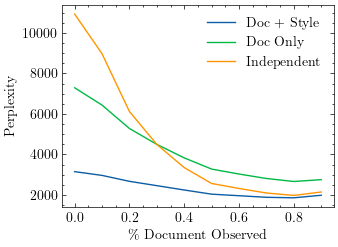

In [222]:
plt.plot(PERC_OBS_VALS, doc_perps, label = 'Doc + Style')
plt.plot(PERC_OBS_VALS, doc_only_perps, label = 'Doc Only')
plt.plot(PERC_OBS_VALS, indep_doc_perps, label = 'Independent')

plt.xlabel('\% Document Observed')
plt.ylabel('Perplexity')

plt.legend()

plt.savefig('perp_observed_curve_20.png')

# Loss Curve 

In [223]:
indep_losses     = pd.read_csv(f'{"/".join(CHOSEN_INDEP_MODEL.split("/")[:-1])}/elbos.json')
prod_slda_losses = pd.read_csv(f'{"/".join(CHOSEN_MODEL.split("/")[:-1])}/elbos.json')

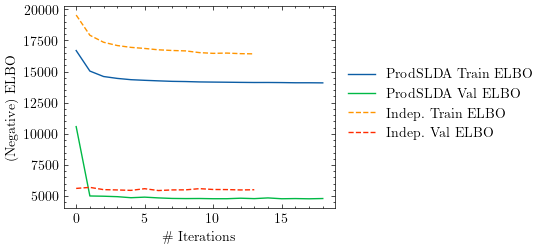

In [224]:
plt.plot(range(len(prod_slda_losses)), prod_slda_losses['train_elbo'],
         label = 'ProdSLDA Train ELBO')
plt.plot(range(len(prod_slda_losses)), prod_slda_losses['val_elbo'],
         label = 'ProdSLDA Val ELBO')
plt.plot(range(len(indep_losses)), indep_losses['train_elbo'], 
         linestyle = 'dashed',
         label = 'Indep. Train ELBO')
plt.plot(range(len(indep_losses)), indep_losses['val_elbo'],  
         linestyle = 'dashed',
         label = 'Indep. Val ELBO')

plt.legend(bbox_to_anchor = (1, 0.75))
plt.xlabel('\# Iterations')
plt.ylabel('(Negative) ELBO')
plt.savefig('elbo_curve_20.png', dpi = 600)

In [228]:
prod_slda.eval()
prod_islda.eval()
    
beta_doc, beta_style = get_doc_topics(prod_slda, topk = 15)
beta_idoc            = get_doc_topics(prod_islda, topk = 15)

In [229]:
comp_res = defaultdict()
comp_res['model'] = ['ProdSLDA', 'Independent']

doc_coh, _    = topic_coherence(beta_doc, bows['training'])
doc_icoh, _   = topic_coherence(beta_idoc, bows['training'])

style_coh, _  = topic_coherence(beta_style, bows['training'])

doc_div       = topic_diversity(beta_doc)
doc_idiv      = topic_diversity(beta_idoc)

style_div     = topic_diversity(beta_style)

bet_div       = between_topic_diversity(beta_doc, beta_style)

comp_res['top_coh']   = [doc_coh, doc_icoh]
comp_res['style_coh'] = [style_coh, None]
comp_res['top_div']   = [doc_div, doc_idiv]
comp_res['style_div'] = [style_div, None]
comp_res['bet_div']   = [bet_div, None]

In [230]:
print(pd.DataFrame(comp_res).to_latex(index = None, column_format = 'cccccc'))

\begin{tabular}{cccccc}
\toprule
       model &  top\_coh &  style\_coh &  top\_div &  style\_div &  bet\_div \\
\midrule
    ProdSLDA &    0.186 &      0.161 &    0.993 &      0.953 &    0.842 \\
 Independent &    0.173 &        NaN &    0.803 &        NaN &      NaN \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3043555/2432429119.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(comp_res).to_latex(index = None, column_format = 'cccccc'))
